In [1]:
import os
from os import system, getpid, walk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random as python_random
import gc
from psutil import Process;
import joblib
from joblib import Parallel, delayed

from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras import mixed_precision # for support mixed precision training
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [2]:
#Basic Info for Data Frame
# stock_id - A unique identifier for the stock. Not all stock IDs exist in every time bucket.
                              
# date_id - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
                              
# imbalance_size - The amount unmatched at the current reference price (in USD).

# imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.
# -buy-side imbalance; 1
# -sell-side imbalance; -1
# -no imbalance; 0

# reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, 
# in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
    
# matched_size - The amount that can be matched at the current reference price (in USD).

# far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.

# near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders.

# [bid/ask]_price - Price of the most competitive buy/sell level in the non-auction book.

# [bid/ask]_size - The dollar notional amount on the most competitive buy/sell level in the non-auction book.

# wap - The weighted average price in the non-auction book.
# =(BidPrice*AskSize + AskPrice * BidSize)/(BidSize+AskSize)

# seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.

# target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
# -The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
# -The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
# -Where t is the time at the current observation, we can define the target:
# Target=((StockWAP_t+60 / StockWAP_t)-(IndexWAP_t+60 / IndexWAP_t)) * 10000


In [3]:
#Constants
SEED = 42

N_LAGS =    20#12#6#3 #30 #4#20#55#10 #4 # 2 # define window size(N_Lags + 1)

BATCH_SIZE =   32 
BUFFER_SIZE = 100000 
EPOCHS =   200 
PATIENCE =  10
DROPOUT = 0.5
LEARNING_RATE = 1e-4

N_STOCKS = 200  # define the maximum stock id 
N_DATES = 481 # define the maximum stock dates
N_SECONDS = 55  # define the maximum seconds 0- 540 second for each day
SPLIT_DAY = 390 #set split day 

RUN_TRAINING = True
RUN_IN_KAGGLE = False
RUN_FOR_SUBMISSION = False

In [4]:
if RUN_IN_KAGGLE:
    trainPath= "/kaggle/input/optiver-trading-at-the-close/train.csv"
else:
    trainPath = "/Users/Brady/Kaggle/optiver/train.csv"



In [5]:
df = pd.read_csv(trainPath, engine="pyarrow")
df = df[["stock_id", "date_id", "seconds_in_bucket", "target"]]

In [6]:
#Reduces memory usage via checking smallests applicable data type for each val
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    if verbose:
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        print(f"Decreased by {decrease:.2f}%")

    return df

df = reduce_mem_usage(df, verbose=1)

Memory usage of dataframe is 159.85 MB
Memory usage after optimization is: 49.95 MB
Decreased by 68.75%


In [7]:
all_stock_ids = range(N_STOCKS)
all_date_ids = range(N_DATES) 
all_seconds = [i * 10 for i in range(N_SECONDS)]

#Reindex full dataframe 
multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds], 
                                         names=['stock_id', 'date_id', 'seconds_in_bucket'])
df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
df_full = df_full.fillna(0) # fill NA (miss value) into 0 
df_full = df_full.reset_index()
assert(df_full.shape[0] == N_STOCKS * N_DATES * N_SECONDS)

In [8]:
gc.collect()

0

In [9]:
def visualize(df, stock_id, date_id):
    df1 = df[(df.stock_id == stock_id) & (df.date_id == date_id)].copy()
    df1.plot(x="seconds_in_bucket", y=["bid_price", "ask_price", "far_price", "near_price", "reference_price"])
    plt.title("bid_price, ask_price, far_price, near_price")
    plt.show()
    df1.plot(x="seconds_in_bucket", y=["bid_price","ask_price", "wap", "reference_price"])
    plt.title("bid_price, ask_price, wap, refence_price")
    plt.show()
    df1.plot(x="seconds_in_bucket", y=["target"])
    plt.title("target")
    plt.show()
    df1.plot(x="seconds_in_bucket", y=["bid_size", "ask_size"])
    plt.title("bid_size, ask_size")
    plt.show()
    df1.plot(x="seconds_in_bucket", y=['imbalance_size','matched_size'])
    plt.title("Imbalance_size, matched_size")
    plt.show()

In [10]:
%%time
df1 = pd.read_csv(trainPath, engine="pyarrow") #pyarrow for multi threading

CPU times: total: 23.3 s
Wall time: 6.31 s


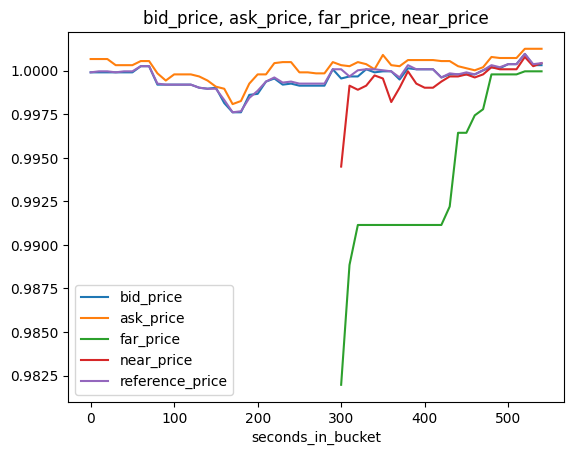

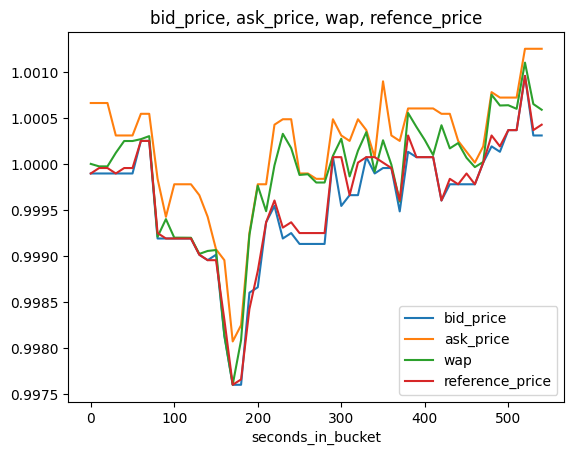

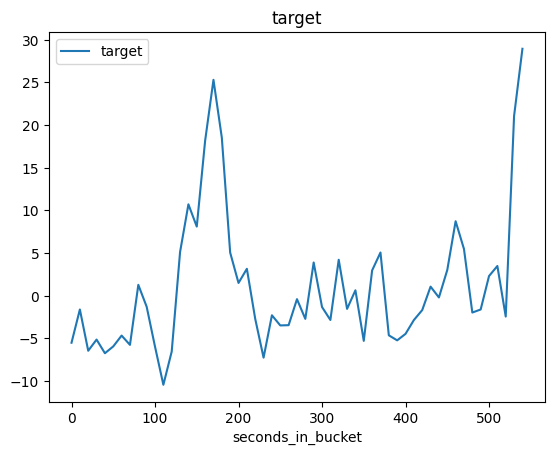

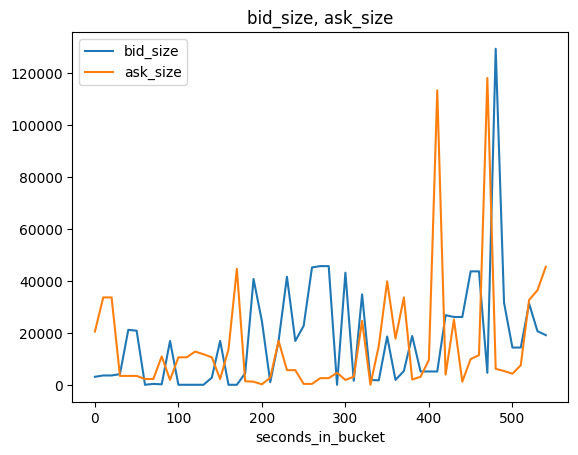

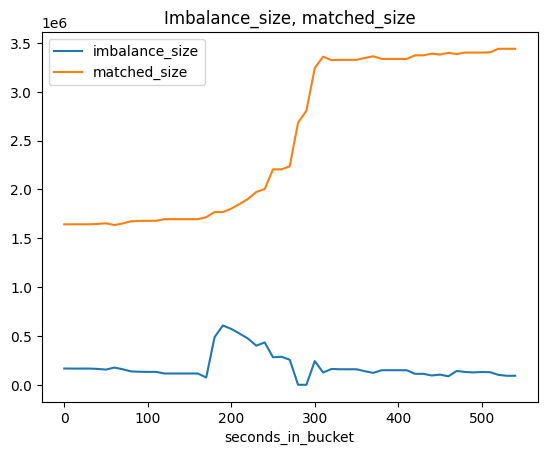

In [11]:
visualize(df1, 1, 0)

In [12]:
def windowed_dataset(series, window_size=N_LAGS, batch_size=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
def windowed_dataset2(dataset, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(N_LAGS + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(N_LAGS + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

In [14]:
def build_features(df):
    all_stock_ids = range(N_STOCKS)
    all_date_ids = df["date_id"].unique() # find unqiue date id 
    all_seconds = [i * 10 for i in range(N_SECONDS)]
    
    # Set multi-index (stock_id, date_id, seconds_in_bucket)
    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds], 
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_full = df_full.fillna(0) # fill missing value with 0
    df_full = df_full.reset_index()
    
    #create pivot table 
    df_pivoted = df_full.pivot_table(
                values='target',       # set each row value is taget
                index=['date_id', 'seconds_in_bucket'], # ste date_id, seconds_in_bucket for index 
                columns='stock_id')   # set stock_id  for column 

    df_pivoted = df_pivoted.reset_index(drop=True) # remove new date_id, second_in_bucket index  
    df_pivoted.columns.name = None 
    
    return df_pivoted


testFeature = build_features(df_full)

In [15]:
def build_model(dropout=DROPOUT):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Dropout(dropout))
    model.add(LSTM(25, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))
    model.compile(loss='mae',
    optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE))
    return model

In [16]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)



Epoch 1/200

672/672 [==============================] - 20s 23ms/step - loss: 0.7379 - val_loss: 0.6873
Epoch 2/200
672/672 [==============================] - 15s 22ms/step - loss: 0.7297 - val_loss: 0.6823
Epoch 3/200
672/672 [==============================] - 15s 22ms/step - loss: 0.7232 - val_loss: 0.6779
Epoch 4/200
672/672 [==============================] - 15s 22ms/step - loss: 0.7176 - val_loss: 0.6744
Epoch 5/200
672/672 [==============================] - 15s 22ms/step - loss: 0.7133 - val_loss: 0.6719
Epoch 6/200
672/672 [==============================] - 15s 22ms/step - loss: 0.7101 - val_loss: 0.6701
Epoch 7/200
672/672 [==============================] - 14s 21ms/step - loss: 0.7077 - val_loss: 0.6684
Epoch 8/200
672/672 [==============================] - 14s 21ms/step - loss: 0.7057 - val_loss: 0.6670
Epoch 9/200
672/672 [==============================] - 14s 21ms/step - loss: 0.7037 - val_loss: 0.6656
Epoch 10/200
672/672 [==============================] - 14s 21ms/step -

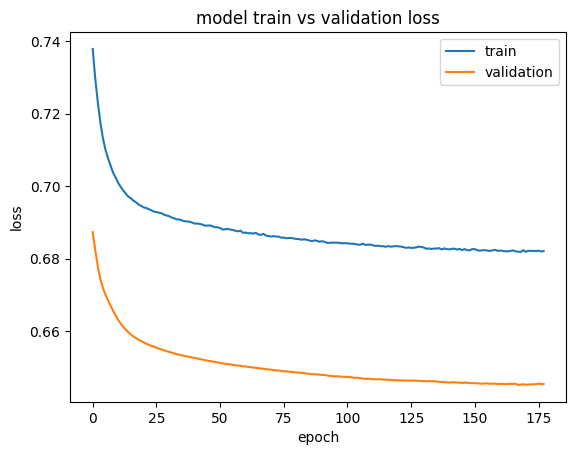

CPU times: total: 19min
Wall time: 29min 9s


In [17]:
%%time 
if RUN_TRAINING:
    # split data 
    split = df_full['date_id'] > SPLIT_DAY
    df_train = df_full[~split]
    df_valid = df_full[split]
    
    df_train_features = build_features(df_train)
    df_valid_features = build_features(df_valid)

    scaler = StandardScaler()
    train_features = scaler.fit_transform(df_train_features)
    valid_features = scaler.transform(df_valid_features)
 
    train_dataset = windowed_dataset2(train_features)
    valid_dataset = windowed_dataset2(valid_features, shuffle=False)
 
    train_dataset = windowed_dataset(train_features)
    with strategy.scope():
        model = build_model() 

    early_stopping = EarlyStopping(monitor='val_loss',
                      mode='min',
                      patience=PATIENCE,
                      restore_best_weights=True,
                      verbose=True)

    history = model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[early_stopping],
                        verbose=True)

    ## Evaluate ## 
    y_pred = model.predict(valid_dataset)

    y_pred = scaler.inverse_transform(y_pred)
    y_true = df_valid_features[N_LAGS:]

    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"MAE score: {mae}")

    ## Plots ##
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [18]:
mape = mean_absolute_percentage_error(y_true,y_pred)

In [19]:
if RUN_FOR_SUBMISSION:
    
    import optiver2023
    optiver2023.make_env.func_dict['__called__'] = False
    env = optiver2023.make_env()
    iter_test = env.iter_test()
    
    counter = 0
    
    
    for i, (test, revealed_targets, sample_prediction) in enumerate(iter_test): # reveal 3 test file 
    
        if test.currently_scored.iloc[0]== False:  # for initial for 
            sample_prediction['target'] = 0 # set sample prediction target value to 0
            env.predict(sample_prediction)
            counter += 1
            continue        
    
        if test.seconds_in_bucket.unique()[0] == 0:
            # select used column
            df_revealed_targets = revealed_targets[["stock_id", "revealed_date_id", "seconds_in_bucket", "revealed_target"]]
            df_revealed_targets = df_revealed_targets.rename(columns={'revealed_date_id': 'date_id', 'revealed_target': 'target'})

            df_features = build_features(df_revealed_targets)  #build feature 

            history_scaled = scaler.transform(df_features) # scale the featrure 
        
        # predict the target value
        y_pred_scaled = model.predict(
            history_scaled[-N_LAGS:][np.newaxis, :, :],
            verbose=True)
        
        y_pred = scaler.inverse_transform(y_pred_scaled)
        
        sample_prediction['target'] = y_pred[0]
        env.predict(sample_prediction)
        counter += 1
        
        history_scaled = np.concatenate([history_scaled, y_pred_scaled])
        print("Ran")
else:
    print("No Submission")

No Submission
